In [101]:
from sympy import init_session
init_session()



IPython console for SymPy 1.12.1 (Python 3.12.4-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12.1/



In [15]:
# Nr. 2
U0 = 200e3
f = 20e6
omega = 2*pi*f

# a)
Ekin = 20e6 * c.e
DE = c.e* U0
print(float(Ekin/DE))
print(float(671.4629/f *sqrt(DE/(2*c.m_p))))

# b)
print(f"B = {c.m_p * omega / c.e:.6f}")
print(f"r_max = {1/omega*sqrt(2*Ekin/c.m_p):.6f}")

100.0
103.90784325148297
B = 1.311889
r_max = 0.492580


In [24]:
# Nr.3
nB = 2808
N = 115e9
sigma = 15e-6
l = 26.695e3
eta = 0.25

# a)
L = nB * c.c * N**2 /(4*pi*l * sigma**2)
print(f"L = {float(L):.3E}")

# b)
L_int = L * eta * 6*30*24*60**2
print(f"L_int = {float(L_int):.3}")

# c)
sigma = 20e-12*1e-28
N = L_int * sigma 
print(f"N = {float(N):.3}")

L = 1.475E+38
L_int = 5.73e+44
N = 1.15e+06


In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import pi, sqrt, log
from astropy.constants import alpha
plt.rcParams.update({"xtick.top": True , "ytick.right": True,
"xtick.minor.visible": True, "ytick.minor.visible": True,
"xtick.direction": "in" , "ytick.direction": "in",
"axes.labelsize": "large", "text.usetex": False, "font.size": 11
})

# Nr.4
c,hbar,epsilon0,kB = 1,1,1,1
m_e = 0.51 # MeV
K = 0.307 # MeV / g / cm^2
rho = 1.06 # g / cm^3
ZA = 0.53768
I = 68.7e-6 # MeV
L = 1 # cm

particles = ["muon", "pion", "kaon", "proton", "alpha"]
particle_masses = [105.7, 139.6, 493.7, 938.3, 3727.4] # MeV
particle_charges = [1,1,1,1,2] * sqrt(4*pi*alpha) # 1


gamma = lambda p,M: sqrt(1 + (p / M)**2)
beta = lambda p,M: sqrt(1 - 1 / (gamma(p,M))**2)

W_max = lambda p,M: 2 * m_e * c**2 * beta(p,M)**2 * gamma(p,M)**2 / (1 + 2*gamma(p,M)*m_e/M + (m_e/M)**2)

dEdx = lambda p,M,z: K * rho * z**2 * ZA / beta(p,M)**2 * gamma(p,M)**2 / (1/2 * np.log(2 * m_e * c**2 * beta(p,M)**2 * gamma(p,M)**2 * W_max(p,M) / I**2) - beta(p,M)**2) 



muon  :    argmin        = 114.1 MeV
           dE/dx(argmin) = 0.0070069 MeV/cm
pion  :    argmin        = 150.91 MeV
           dE/dx(argmin) = 0.0070055 MeV/cm
kaon  :    argmin        = 531.72 MeV
           dE/dx(argmin) = 0.0070029 MeV/cm
proton:    argmin        = 1010.1 MeV
           dE/dx(argmin) = 0.0070024 MeV/cm
alpha :    argmin        = 4014.3 MeV
           dE/dx(argmin) = 0.028008 MeV/cm


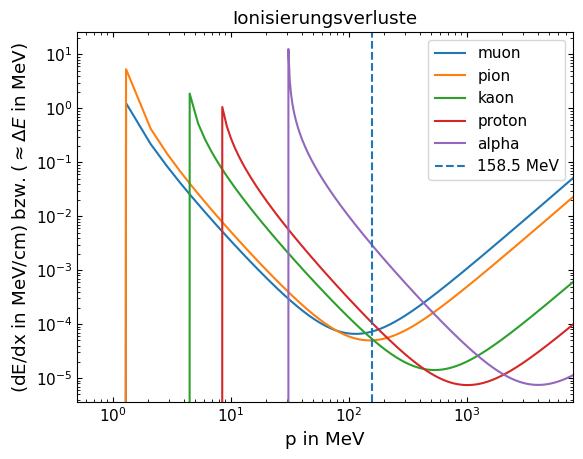

In [121]:
xlim = [1/2,8000]
p = np.linspace(*xlim,10000)
fig,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set(xlabel="p in MeV",ylabel="(dE/dx in MeV/cm) bzw. ($\\approx \\Delta E$ in MeV)", xlim=xlim, title="Ionisierungsverluste")

for particle, mass, charge in zip(particles, particle_masses, particle_charges):
    DE = [dEdx(p, mass, charge) for p in p]
    ax.plot(p, np.divide(DE,mass), label=particle)
    argmin = np.argmin(DE[np.argmax(DE):])
    min = p[argmin]
    print(f"{particle:6}:    argmin        = {min:.5} MeV")
    print(f"{"":11}dE/dx(argmin) = {DE[argmin]:.5} MeV/cm")

ax.axvline(10**2.2, linestyle="--", label="158.5 MeV")
ax.legend()
fig.savefig("2.svg")


In [30]:
"""
Calculation of Bethe-Bloch energy loss with:
- density correction
- cut off energy

MPV calculation with Landau theory
"""

from math import sqrt, log
sqr = lambda x: x*x
import matplotlib.pyplot as plt
import numpy as np

""" Constants and formulas to be used for pion """
K = 0.307075 # constant K in MeV cm mol^-1
z = 1 # charge in e
Z = 14 # Atomic number Z
A = 28.09 # Atomic mass in g mol-1
Z_over_A = float(Z/A) # Silicon
M = 139.6 # Mass of heavy particle in MeV
m_e = 0.511 # Mass of electron in MeV
rho = 2.336 # Density of material in g cm^-3 (here: silicon density)
gamma = lambda p: sqrt(1 + sqr(p / M))
beta = lambda p: sqrt(1 - 1 / sqr(gamma(p)))
beta_gamma = lambda p: p / M
T_max = lambda p: 2 * m_e * sqr(beta_gamma(p)) / (1 + 2 * gamma(p) * m_e / M + sqr(m_e / M)) # Maximum energy transfer in one collision in MeV
h_omega_p = 0.00003105 # Plasma energy in MeV

T_kin_heavy = lambda p: sqrt( sqr(p) + sqr(M) ) - M

T_cut = 0.06 # Cut energy due to finite thickness of absorber in MeV
I = 0.000173 # Ionisation energy in MeV

""" Constants of density correction """
C = 4.44
a = 0.1492
m = 3.25
X1 = 2.87
X0 = 0.2014
delta0 = 0.14
X = lambda p: np.log10(beta_gamma(p))
#f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
f1 = lambda x: 0 # non conductors pdg
f2 = lambda x: 2 * x * np.log(10) - C + (a * ((X1 - x)**m))
f3 = lambda x: 2 * x * np.log(10) + C
delta_full = lambda x: np.piecewise(x, [x < X0 , x >= X0], [f1, f2])

""" Thickness of absorber """
thickness_um = 50
x = thickness_um/10000.0  # x in cm

epsilon = (K * rho * Z * x) / (2 * A) # Has to have units MeV
print ('epsilon = ', epsilon)
E_mean_delta_corr = lambda p:  epsilon * (log(2 * m_e * T_max(p) * sqr(beta_gamma(p)) / sqr(I)) - 2 * sqr(beta(p)) - delta_full( X(p) ) ) / sqr(beta(p)) # 
E_mean = lambda p:  epsilon * (log(2 * m_e * T_max(p) * sqr(beta_gamma(p)) / sqr(I)) - 2 * sqr(beta(p)) ) / sqr(beta(p)) # 
E_mean_delta_corr_Tcut = lambda p:  epsilon * (log(2 * m_e * T_cut * sqr(beta_gamma(p)) / sqr(I)) - 2 * sqr(beta(p)) * (1 + T_cut/T_max(p)) - delta_full( X(p) ) ) / sqr(beta(p)) # 

E_MPV_LVB = lambda p:  epsilon * ( log( ( 2 * m_e * sqr( beta_gamma(p) ) ) / I ) + log( epsilon / ( I * sqr(beta(p)) ) ) +  0.2 - sqr( beta(p) ) - delta_full( X(p) ) )  / sqr(beta(p)) # pdg

E_MPV_limit = lambda p:  epsilon * ( log( ( 2 * m_e * epsilon ) / sqr(h_omega_p) )  +  0.2 )


""" Calculation of all formulas in momentum range ps """

ps = np.logspace(2, 5, 1000) # MeV

dE_over_dX_pions = np.zeros(len(ps))
dE_over_dX_Tcut_pions = np.zeros(len(ps))

beta_gammas = np.zeros(len(ps))
Xs = np.zeros(len(ps))
density_correction = np.zeros(len(ps))
betas = np.zeros(len(ps))
ps_GeV = np.zeros(len(ps))

E_means = np.zeros(len(ps))
E_mean_density_corr = np.zeros(len(ps))
E_mean_density_corr_Tcut = np.zeros(len(ps))

E_MPVs_Landau = np.zeros(len(ps))
E_MPVs_Landau_limit = np.zeros(len(ps))

T_kins = np.zeros(len(ps))

for pi in range(0, len(ps)):
	# dE_over_dX_pions[pi] = dE_over_dX(ps[pi])
	# dE_over_dX_Tcut_pions[pi] = dE_over_dX_Tcut(ps[pi])

	beta_gammas[pi] = beta_gamma(ps[pi])
	density_correction[pi] = delta_full(ps[pi])
	betas[pi] = beta(ps[pi])
	
	Xs[pi] = X( ps[pi] )	
	E_mean_density_corr[pi] = E_mean_delta_corr( ps[pi] ) * 1000
	E_mean_density_corr_Tcut[pi] = E_mean_delta_corr_Tcut( ps[pi] ) * 1000
	E_means[pi] = E_mean( ps[pi] ) * 1000
	E_MPVs_Landau[pi] = E_MPV_LVB( ps[pi] ) * 1000
	E_MPVs_Landau_limit[pi] = E_MPV_limit( ps[pi] ) * 1000
	ps_GeV[pi] = ps[pi]/1000.0

	T_kins[pi] = T_kin_heavy( ps[pi] )
	
print (' betas = ', betas)
dE_pions_450um = np.multiply(dE_over_dX_pions, 0.045*1000)
dE_pions_Tcut_450um = np.multiply(dE_over_dX_Tcut_pions, 0.045*1000)

""" Plot density correction and kinetic energy """

fig = plt.figure('Density correction control plot of X=log10(beta(p)*gamma(p))', figsize=(10, 5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1,2,1)
my_font = 16
plt.tick_params(axis='both', which='major', labelsize=my_font)
plt.plot(ps, Xs, label='X', marker='o', color='Gray', linestyle='', linewidth=5, alpha=0.5)
plt.grid(True, which="both", ls="-", color='0.65')
plt.axhline(X0, label = 'X0', color='Black', linewidth=2)
plt.axhline(X1, label = 'X1', color='Red', linewidth=2)
plt.ylabel(r'X = log($\beta\gamma$ (p))', fontsize = my_font)
plt.xlabel('Momentum p [MeV]', fontsize = my_font)
plt.legend(loc='center right')

ax2 = fig.add_subplot(1,2,2)
my_font = 16
plt.tick_params(axis='both', which='major', labelsize=my_font)
plt.plot(ps, T_kins, label='', marker='o', color='Gray', linestyle='', linewidth=5, alpha=0.5)
plt.grid(True, which="both", ls="-", color='0.65')
plt.ylabel('Kinetic energy electron [MeV]', fontsize = my_font)
plt.xlabel('Momentum p [MeV]', fontsize = my_font)
#plt.legend(loc='center right')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.tight_layout()

plt.savefig('Bethe-control-plot-heavy-particle.png')
plt.savefig('Bethe-control-plot-heavy-particle.svg')
#plt.show()
plt.clf()
plt.close()


""" Plot Bethe versus momentum """

fig, ax1 = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_size_inches(8,6)

plt.tick_params(axis='both', which='major', labelsize=my_font)
ax1.plot(ps_GeV, E_means, label='Bethe no correction', marker='', color='Black', linestyle='-', linewidth=2)
ax1.plot(ps_GeV, E_mean_density_corr, label='Bethe density correction', marker='', color='Red', linestyle='--', linewidth=2)
ax1.plot(ps_GeV, E_mean_density_corr_Tcut, label='Bethe Tcut = 60 keV', marker='', color='DarkGreen', linestyle=':', linewidth=2)

ax1.plot(ps_GeV, E_MPVs_Landau, label='MPV Landau', marker='', color='Blue', linestyle='-', linewidth=2)
ax1.plot(ps_GeV, E_MPVs_Landau_limit, label='MPV Landau Limit', marker='', color='Gray', linestyle='-', linewidth=2)

ps_min = ps_GeV[np.where(E_MPVs_Landau[:] == np.min(E_MPVs_Landau))]
print('min '), np.min(E_MPVs_Landau), ps_min
plt.plot(ps_min, np.min(E_MPVs_Landau), marker = 'o', label = 'MPV of MIP = %.2f keV'%np.min(E_MPVs_Landau))

plt.grid(True, which="both", ls="-", color='0.65')
#plt.axvline(120000, label = '120 GeV pions', color='Gray', linewidth=5)
ax1.set_xscale('log')
plt.ylabel('Energy loss in '+str(thickness_um)+' um Si in keV', fontsize = my_font)
plt.xlabel('Momentum p [GeV]', fontsize = my_font)
plt.legend(loc='upper center')

ax2 = ax1.twinx()
energy_to_charge = 3.6
s2 = np.divide(E_MPVs_Landau, energy_to_charge)
ax2.plot(ps_GeV, s2, marker='', color='Blue', linestyle='-', linewidth=2)
ax2.set_ylim(10/energy_to_charge, 45/energy_to_charge)
ax2.set_ylabel('Signal in 1000 e/h pairs', fontsize = my_font)

plt.tick_params(axis='both', which='major', labelsize=my_font)
plt.tight_layout()
plt.savefig('Bethe-for-thickness-'+str(thickness_um)+'um-heavy.png')
plt.savefig('Bethe-for-thickness-'+str(thickness_um)+'um-heavy.svg')
plt.show()


# fig, ax1 = plt.subplots()
# fig.patch.set_facecolor('white')
# fig.set_size_inches(8,6)

# plt.tick_params(axis='both', which='major', labelsize=my_font)
# ax1.plot(beta_gammas, E_means, label='Bethe no correction', marker='', color='Black', linestyle='-', linewidth=2)
# ax1.plot(beta_gammas, E_mean_density_corr, label='Bethe density correction', marker='', color='Red', linestyle='--', linewidth=2)
# ax1.plot(beta_gammas, E_mean_density_corr_Tcut, label='Bethe Tcut = 60 keV', marker='', color='DarkGreen', linestyle=':', linewidth=2)

# ax1.plot(beta_gammas, E_MPVs_Landau, label='MPV Landau', marker='', color='Blue', linestyle='-', linewidth=2)
# ax1.plot(beta_gammas, E_MPVs_Landau_limit, label='MPV Landau Limit', marker='', color='Gray', linestyle='-', linewidth=2)

# ps_min = beta_gammas[np.where(E_MPVs_Landau[:] == np.min(E_MPVs_Landau))]
# print 'min ', np.min(E_MPVs_Landau), ps_min
# plt.plot(ps_min, np.min(E_MPVs_Landau), marker = 'o', label = 'MPV of MIP = %.2f keV'%np.min(E_MPVs_Landau))

# plt.grid(True, which="both", ls="-", color='0.65')
# #plt.axvline(120000, label = '120 GeV pions', color='Gray', linewidth=5)
# ax1.set_xscale('log')
# plt.ylabel('Energy loss in '+str(thickness_um)+' um Si in keV', fontsize = my_font)
# plt.xlabel(r'$\beta\gamma$', fontsize = my_font+2)

# # match to pion data
# E_mean_restricted = E_mean_density_corr_Tcut[np.where(beta_gammas[:]>14)[0][0]]
# print 'E_mean_restricted betagamma 14 = ' , E_mean_restricted

# #plt.plot(14, E_mean_restricted, marker = 'o', markersize=3, label='Emean restricted %.2f keV'%E_mean_restricted, color='DarkGreen')

# plt.legend(loc='upper center')

# ax2 = ax1.twinx()
# energy_to_charge = 3.6
# s2 = np.divide(E_MPVs_Landau, energy_to_charge)
# ax2.plot(beta_gammas, s2, marker='', color='Blue', linestyle='-', linewidth=2)
# ax2.set_ylim(10/energy_to_charge, 45/energy_to_charge)
# ax2.set_ylabel('Signal in 1000 e/h pairs', fontsize = my_font)

# plt.tick_params(axis='both', which='major', labelsize=my_font)

# #plt.xlim(0.7, 700)
# plt.xlim(beta_gammas[0], beta_gammas[-1])

# plt.tight_layout()

# plt.legend(loc='upper center')

# plt.savefig('bethe'+str(thickness_um)+'um-versus-betagamma.png')
# plt.savefig('bethe'+str(thickness_um)+'um-versus-betagamma.svg')

# plt.show()


epsilon =  0.0008937861160555359
 betas =  [0.58233938 0.58500035 0.58766083 0.59032065 0.59297963 0.5956376
 0.59829439 0.60094983 0.60360373 0.60625592 0.60890624 0.6115545
 0.61420052 0.61684413 0.61948516 0.62212343 0.62475876 0.62739098
 0.6300199  0.63264536 0.63526718 0.63788519 0.6404992  0.64310904
 0.64571454 0.64831553 0.65091183 0.65350327 0.65608967 0.65867087
 0.66124669 0.66381696 0.66638152 0.6689402  0.67149282 0.67403923
 0.67657925 0.67911272 0.68163949 0.68415938 0.68667224 0.6891779
 0.69167622 0.69416702 0.69665017 0.69912549 0.70159285 0.70405209
 0.70650306 0.70894562 0.71137961 0.7138049  0.71622134 0.71862879
 0.72102711 0.72341618 0.72579584 0.72816598 0.73052645 0.73287714
 0.73521791 0.73754864 0.73986921 0.74217949 0.74447938 0.74676875
 0.74904749 0.75131549 0.75357264 0.75581884 0.75805398 0.76027796
 0.76249068 0.76469204 0.76688195 0.76906032 0.77122706 0.77338207
 0.77552528 0.77765661 0.77977597 0.78188328 0.78397848 0.78606149
 0.78813224 0.79019066

C:\Users\Lucac\AppData\Local\Temp\ipykernel_34528\388732762.py:44: RuntimeWarning: invalid value encountered in power
  f2 = lambda x: 2 * x * np.log(10) - C + (a * ((X1 - x)**m))


min 
